### NRK big task - rewrite code below to a) quickly calculate covariance across days in a separate class that does not live in the DimReduction class!, and b) spit out both an across day matrix for doing across-day comparisons but ALSO just the covariance mat for each day. Currently can't look at Marble06 because he didn't make it to day 7.

This notebook tracks the covariance of cells across sessions.  One module saves all cells so that you can easily look at any comparison across successive days, but I also save freeze tuned cells only and the top cells from the 1st 3 PCs for ease.

In [1]:
# Import useful modules
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.gridspec as gridspec
import pandas as pd
from tqdm import tqdm

# Import project specific modules and enable automatic reloading
import sys
from pathlib import Path
import os
eraser_path = Path(os.getcwd()).parent
reinstatement_path = eraser_path.parent / 'FearReinstatement'
sys.path.append(str(eraser_path))
sys.path.append(str(reinstatement_path))
%load_ext autoreload
%autoreload 2

from session_directory import find_eraser_directory as get_dir
import er_plot_functions as erp
import Placefields as pf
import freezing_analysis as fa
import helpers 
import eraser_reference as err

# Project save directory here
print_dir = '/Users/nkinsky/Documents/BU/Working/Eraser/plots'
save_dir = '/Users/nkinsky/Documents/BU/Working/Eraser'

In [2]:
# Helper functions to block printing output
import sys, os

# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__


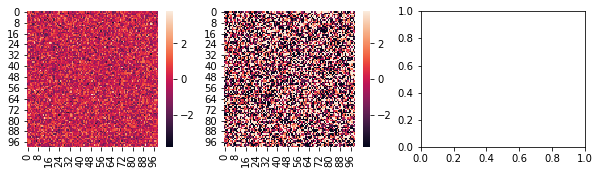

In [3]:
import matplotlib

def get_quadmesh(ax):
    """Grab QuadMesh children of a particular axes only"""
    quad_ind = np.where([isinstance(child, matplotlib.collections.QuadMesh) 
                 for child in ax.get_children()])[0][0]
        
    return ax.get_children()[quad_ind]

def set_clim(ax, ida):
    """Sets clim to for all plots in ax to that in ax[ida]"""
    quad_use = get_quadmesh(ax[ida])
    clim_use = quad_use.get_clim()
    for a in ax.reshape(-1):
        try:
            quad_set = get_quadmesh(a)
            quad_set.set_clim(clim_use)
        except IndexError:
            pass
        
# Unit test for above
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
fig, ax2 = plt.subplots(1, 3, figsize=(10, 2.5))
sns.heatmap(np.random.randn(100, 100), ax=ax2[0])
sns.heatmap(np.random.randn(100,100)*5, ax=ax2[1])
set_clim(ax2, 0)

# Big question: Are our Learner v Nonlearner groupings appropriate?  Marble29 seems to have a lot of consistency in freezing cells across days - maybe he freezes a lot and just doesn't discriminate between arenas?

Write a function to quickly assemble cov mats across days....

In [41]:
import eraser_reference as err
import os

def group_cov_across_days(bin_size: float, arena1: str in ['Open', 'Shock'], arena2: str in ['Open', 'Shock'],
                         neurons: str in ['freeze_onset', 'move_onset', 'all'] or np.ndarray = 'freeze_onset',
                         keep_silent: bool = False, buffer_sec: int or list or tuple = (6, 6)):
    """Assemble all across-day covariance matrices into a dictionary for easy manipulating later on"""

    plot_dir = '/Users/nkinsky/Documents/BU/Working/Eraser/plots'
    group_plot = [err.learners, err.nonlearners, err.ani_mice_good]
    group_names = ['Learners', 'Non-learners', 'ANI']

    cov_dict = dict.fromkeys(group_names)
    for group, name in zip(group_plot, group_names):
        cov_dict[name] = dict.fromkeys(group)
        for mouse in group:
            day1 = [-2, -1, 4, 1, 2, 4]
            day2 = [-1, 4, 1, 2, 7, 2]
            cov_dict[name][mouse] = {}
            for ida, (d1, d2) in tqdm(enumerate(zip(day1, day2)), desc=mouse):
                cbar_bool = ida == 0
                cov_dict[name][mouse][f'{d1}_{d2}'] = []
                try:
                    blockPrint()
                    CMR = fa.CovMatReg(mouse, arena1, d1, arena2, d2, bin_size=bin_size)
                    covz_comb = CMR.cov_across_days(neurons, keep_silent=keep_silent, buffer_sec=buffer_sec)
                    enablePrint()
                    cov_dict[name][mouse][f'{d1}_{d2}'].append(covz_comb)
                except FileNotFoundError:
                    ax[0, ida].text(0.1, 0.5, 'Session(s) missing') 
    
    return cov_dict
            

# NRK todo:

1) Put all these functions into a CMRgroup class? or keep here for reference?
2) Start making plots and putting into figures with stats!!!
3) Track changes across days - would expect more changes (or less changes???) in all cell covariances across days for Ctrl vs. ANI.

## Now start analyzing the cov data

To start, plot covariance of all cells from one day to the next - do they fire together or do they change? May need to only look at tightly coupled cells

In [4]:
def plot_pw_cov_across_days(dict_use, ndays, include_silent, **kwargs):
    """Plots pairwise covariance across days"""
    for group_name in dict_use.keys():
        group_dict = dict_use[group_name]
        for mouse_name in group_dict.keys():
            mouse_dict = group_dict[mouse_name]
        #         ndays = len(mouse_dict.keys())
            fig, ax = plt.subplots(1, ndays, figsize=(3*ndays, 2.5))
            for idd, d1_d2 in enumerate(mouse_dict.keys()):
                cov_mat = mouse_dict[d1_d2]
                day1, day2 = d1_d2.split('_')
                fa.scatter_cov_across_days(cov_mat, include_silent=include_silent, xlabel=f'Day {day1}', 
                                           ylabel=f'Day {day2}', ax=ax[idd], **kwargs)
            fig.suptitle(mouse_name)

In [5]:
def get_cov_pairs_across_days(dict_use, include_silent):
    pairs_dict = dict.fromkeys(dict_use.keys())
    for group_name in dict_use.keys():
        group_dict = dict_use[group_name]
        pairs_dict[group_name] = dict.fromkeys(group_dict.keys())
        for mouse_name in group_dict.keys():
            mouse_dict = group_dict[mouse_name]
            pairs_dict[group_name][mouse_name] = dict.fromkeys(mouse_dict.keys())
            for idd, d1_d2 in enumerate(mouse_dict.keys()):
                cov_mat = mouse_dict[d1_d2]
                cov_pairs = fa.scatter_cov_across_days(cov_mat, include_silent=include_silent, plot=False)
                pairs_dict[group_name][mouse_name][d1_d2] = cov_pairs
    
    return pairs_dict

In [6]:
cov_dict_full = np.load(os.path.join(save_dir, 'all_cells_cov_across_days.npy'), allow_pickle=True).item()
cov_pairs = get_cov_pairs_across_days(cov_dict_full, False)

<AxesSubplot:>

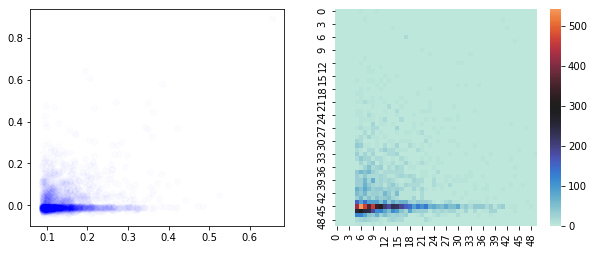

In [12]:
pairs_use = cov_pairs['Learners']['Marble07']['-1_4']
thresh = 2 * np.std(pairs_use[0])
pairs_use = pairs_use[:, pairs_use[0] > thresh]
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].scatter(pairs_use[0], pairs_use[1], color=[0, 0, 1, 0.01])

range_use = np.vstack((ax[0].get_xlim(), ax[0].get_ylim()))
range_use = [[0.05, 0.4], [-0.05, 0.4]]
H, xedges, yedges = np.histogram2d(pairs_use[0], pairs_use[1], range=range_use, bins=50, density=True)
# ax[1].imshow(np.flipud(H))
sns.heatmap(np.flipud(H.T), center = 10 * np.std(H.reshape(-1)))

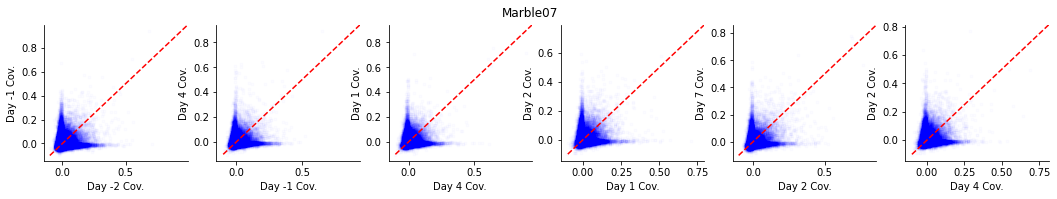

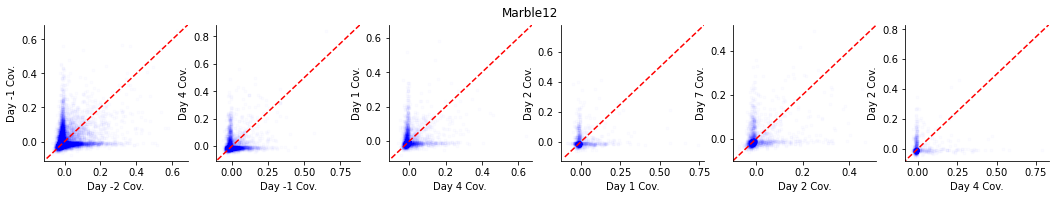

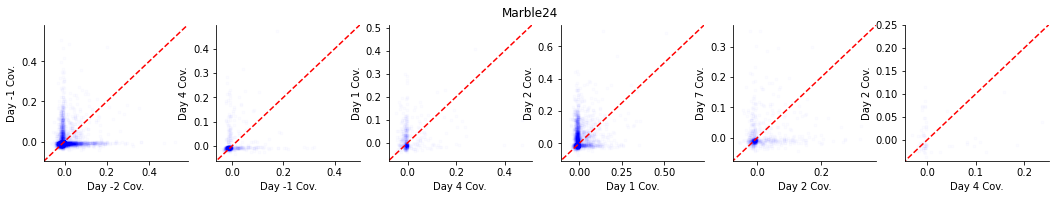

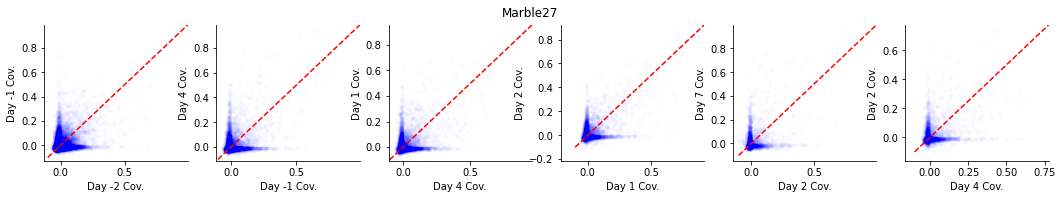

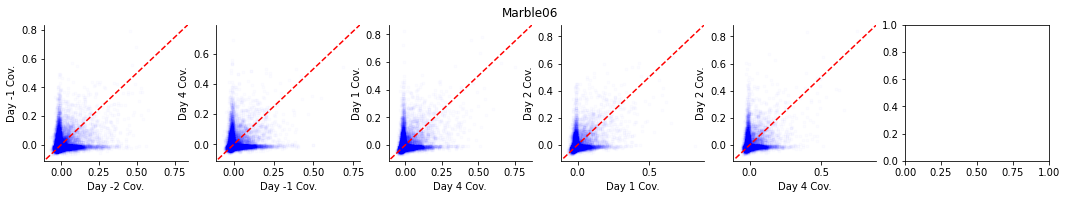

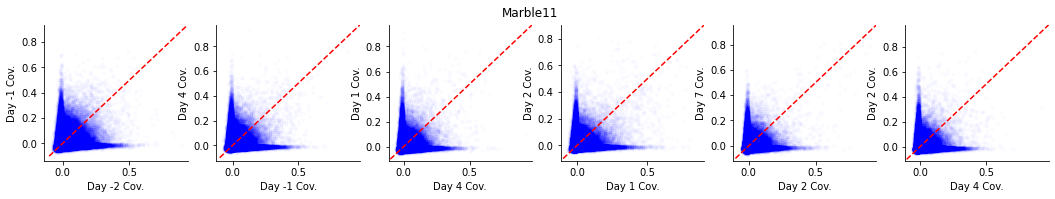

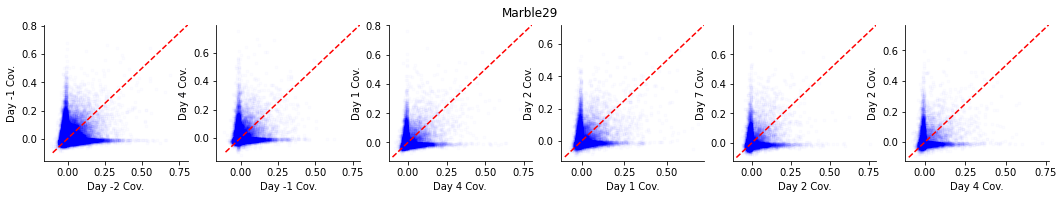

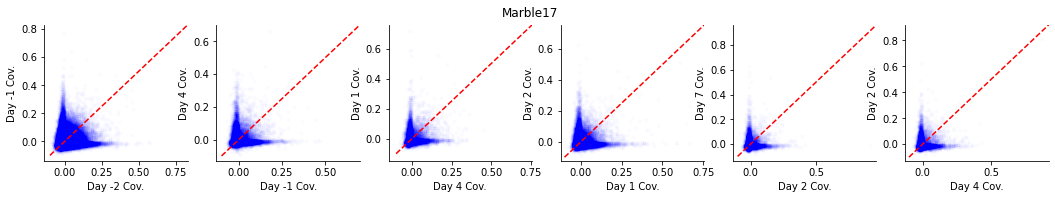

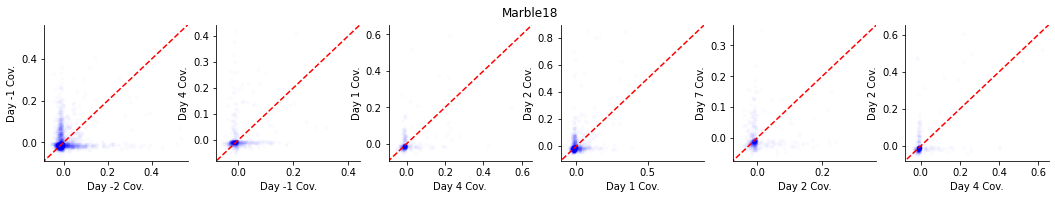

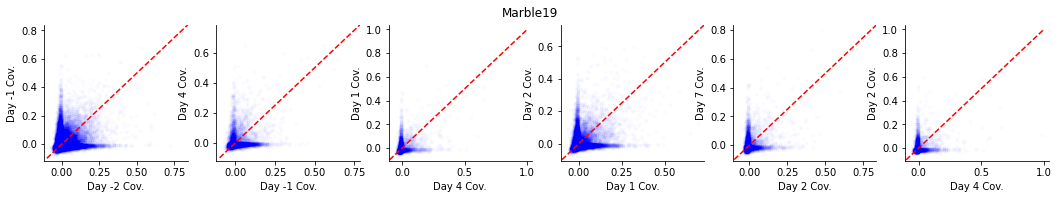

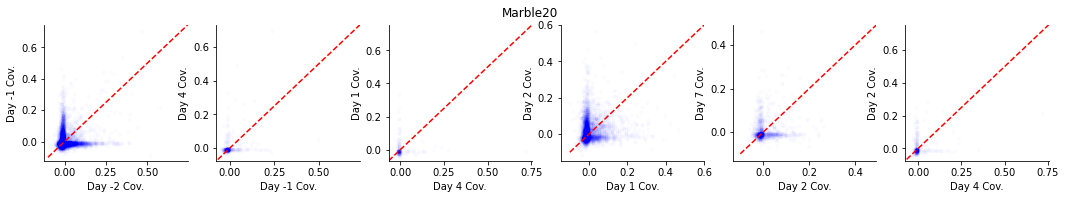

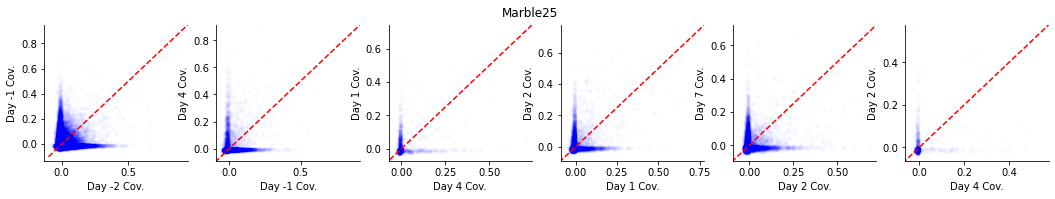

In [8]:
## Load in previously save across-day covariance matrices
cov_dict_full = np.load(os.path.join(save_dir, 'all_cells_cov_across_days.npy'), allow_pickle=True).item()
freeze_silent_cov = np.load(os.path.join(save_dir, 'freeze_cells_cov_across_days_w_silent.npy'),
                           allow_pickle=True).item()
plot_pw_cov_across_days(cov_dict_full, 6, False, color=[0, 0, 1, 0.01])

## NRK look at different smoothing windows for calculating covariance matrix - at what point does synchrony no longer hold?  
  
Why are there so many freeze cells on day -1? Not that many trials -> false positives?  
  
### OK!!! get z-score of covariance of cells on days -2 and -1 as baseline.  Then plot avg z-score of freeze cells on day 4, 1, 2 for each group to see how well connected they are...

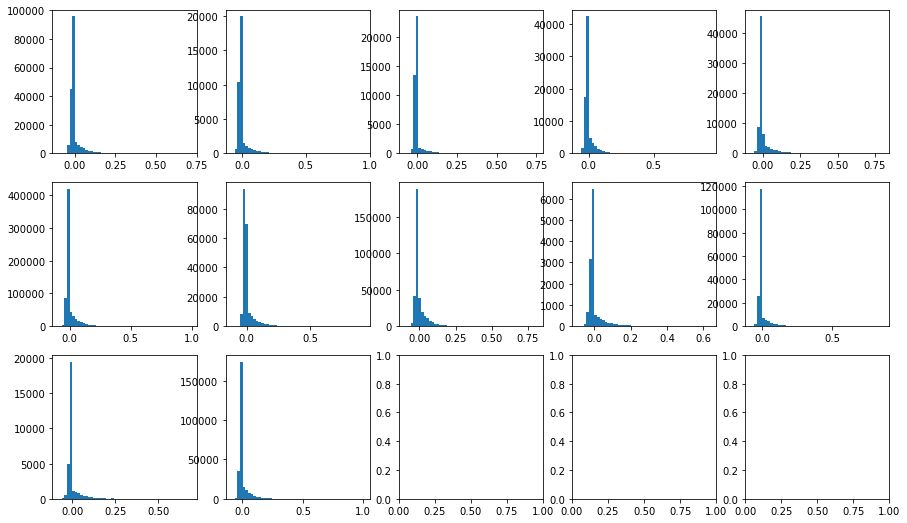

In [14]:
_, axdist = plt.subplots(3, 5, figsize=(15, 9))
dict_use = freeze_silent_cov
include_silent = True
ida = 0
d1_d2 = '-2_-1'
for group_name in dict_use.keys():
    group_dict = dict_use[group_name]
    for mouse_name in group_dict.keys():
        full_mat_use = cov_dict_full[group_name][mouse_name][d1_d2]
#         tril_indices = np.tril_indices_from(full_mat_use, -1)
        base_cov, reg_cov = fa.get_cov_pairs_from_mat(full_mat_use, None, include_silent=include_silent)
        axdist.reshape(-1)[ida].hist(base_cov, bins=50)
        ida += 1

In [42]:
def cov_dict_to_df(dict_use, baseline_dict_use, include_silent: bool = True):
    """Calculate z-scored covariance of all cells in dict compared to pre-shock days for all mice 
     and put into DataFrame
     :param dict_use: dictionary containing covariance mats of cells you want to look at, e.g. freeze cells
     :param baseline_dict_use: dictionary containing covariance mats of cells you want to normalize by, typically all cells
     :para include_silent: bool """

    ida = 0
    day_code, group_code, sigzmean, sigzall = [], [], [], [] # pre-allocate for plotting!
    for group_name in dict_use.keys():
        group_dict = dict_use[group_name]
        
        for mouse_name in group_dict.keys():
            
            # Grab covariance of cells during baseline (day -2 and -1) sessions and calculate mean and std.
            cov_baseline = []
            for d1_d2 in ['-2_-1', '-1_4']:
                base_mat_use = baseline_dict_use[group_name][mouse_name][d1_d2]
                base_cov, _ = fa.get_cov_pairs_from_mat(base_mat_use, None, include_silent=include_silent)
                cov_baseline.extend(base_cov)
            mean_baseline = np.mean(cov_baseline)
            std_baseline = np.std(cov_baseline)
            
            # Grab covariance for cells for each session and normalize by baseline session
            for d1_d2 in ['-2_-1', '-1_4', '4_1', '1_2', '2_7']:
                try:
                    mat_use = dict_use[group_name][mouse_name][d1_d2]
                    base_cov, _ = fa.get_cov_pairs_from_mat(mat_use, None, include_silent=include_silent)
                    sigzall.append((base_cov - mean_baseline)/std_baseline)
                    sigzmean.append(np.mean(sigzall[-1]))
                    group_code.append('ANI') if group_name == 'ANI' else group_code.append('Ctrl')
                    day_code.append(d1_d2)
                except KeyError:
                    pass

    sigz_df = pd.DataFrame(data={'d1_d2': day_code, 'Group': group_code, 'freeze_cov_z_mean': sigzmean_frz}) 
    return sigz_df

In [9]:
# Calculate z-scored covariance of all freeze-tuned cells compared to pre-shock days for all mice 
# and put into DataFrame
dict_use = freeze_silent_cov
include_silent = True
ida = 0
day_code, group_code, sigzmean_frz, sigzall_frz = [], [], [], [] # pre-allocate for plotting!
for group_name in dict_use.keys():
    group_dict = dict_use[group_name]
    for mouse_name in group_dict.keys():
        cov_baseline = []
        for d1_d2 in ['-2_-1', '-1_4']:
            base_mat_use = cov_dict_full[group_name][mouse_name][d1_d2]
            base_cov, _ = fa.get_cov_pairs_from_mat(base_mat_use, None, include_silent=True)
            cov_baseline.extend(base_cov)
        mean_baseline = np.mean(cov_baseline)
        std_baseline = np.std(cov_baseline)
        
        for d1_d2 in ['-2_-1', '-1_4', '4_1', '1_2', '2_7']:
            try:
                mat_use = dict_use[group_name][mouse_name][d1_d2]
                base_cov, _ = fa.get_cov_pairs_from_mat(mat_use, None, include_silent=include_silent)
                sigzall_frz.append((base_cov - mean_baseline)/std_baseline)
                sigzmean_frz.append(np.mean(sigzall_frz[-1]))
                group_code.append('ANI') if group_name == 'ANI' else group_code.append('Ctrl')
                day_code.append(d1_d2)
            except KeyError:
                pass
                    
sigz_df = pd.DataFrame(data={'d1_d2': day_code, 'Group': group_code, 'freeze_cov_z_mean': sigzmean_frz})          

In [10]:
def match_max_lims(ax, axis: str in ['x', 'y', 'both']):
    xlims, ylims = [], []
    for a in ax.reshape(-1):
        xlims.append(a.get_xlim())
        ylims.append(a.get_ylim())
    xlims = np.asarray(xlims)
    ylims = np.asarray(ylims)
    xlim_use = [np.min(xlims.reshape(-1)), np.max(xlims.reshape(-1))]
    ylim_use = [np.min(ylims.reshape(-1)), np.max(ylims.reshape(-1))]
    
    if axis in ['x', 'both']:
        for a in ax.reshape(-1):
            a.set_xlim(xlim_use)
    
    if axis in ['y', 'both']:
        for a in ax.reshape(-1):
            a.set_ylim(ylim_use)

In [27]:
def stats_before_after(df_use, key_use):
    """Compares mean covariances in a DataFrame. Pools days before (-2 and -1) and days after (1 and 2) shock + 
    injection. Compares across and within groups."""
    
    df_after = df_use[np.bitwise_or(df_use['d1_d2'] == '1_2', df_use['d1_d2'] == '2_7')]
    df_before = df_use[np.bitwise_or(df_use['d1_d2'] == '-2_-1', df_use['d1_d2'] == '-1_4')]
    df4 = df_use[df_use['d1_d2'] == '4_1']
    stat_bef, p_bef = stats.ttest_ind(df_before[df_before['Group'] == 'Ctrl'][key_use], 
                                     df_before[df_before['Group'] == 'ANI'][key_use])
    stat_aft, p_aft = stats.ttest_ind(df_after[df_after['Group'] == 'Ctrl'][key_use], 
                                     df_after[df_after['Group'] == 'ANI'][key_use])
    stat_ctrl, p_ctrl = stats.ttest_ind(df_before[df_before['Group'] == 'Ctrl'][key_use], 
                                     df_after[df_after['Group'] == 'Ctrl'][key_use])
    stat_ani, p_ani = stats.ttest_ind(df_before[df_before['Group'] == 'ANI'][key_use], 
                                     df_after[df_after['Group'] == 'ANI'][key_use])
    print(f'p={p_bef:0.3g} baseline b/w groups')
    print(f'p={p_aft:0.3g} day 1-2 b/w groups')
    print(f'p={p_ctrl:0.3g} before-after Ctrl')
    print(f'p={p_ani:0.3g} before-after ANI')

p=0.103 baseline b/w groups
p=0.0203 day 1-2 b/w groups
p=0.00361 before-after Ctrl
p=0.0503 before-after ANI


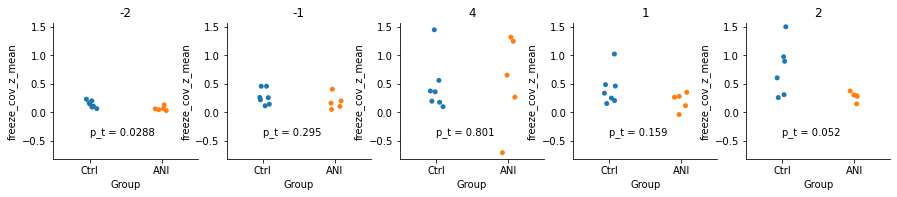

In [28]:
pairs_plot = ['-2_-1', '-1_4', '4_1', '1_2', '2_7']
fig, ax = plt.subplots(1, len(pairs_plot), figsize=(3*len(pairs_plot), 2.5))
for a, d1_d2 in zip(ax, pairs_plot):
    sns.stripplot(x='Group', y='freeze_cov_z_mean', data=sigz_df[sigz_df['d1_d2'] == d1_d2], ax=a)
    sns.despine(ax=a)
    a.set_title(d1_d2.split('_')[0])
    df_use = sigz_df[sigz_df['d1_d2'] == d1_d2]
    stat, pval = stats.ttest_ind(df_use[df_use['Group'] == 'Ctrl']['freeze_cov_z_mean'], 
                                 df_use[df_use['Group'] == 'ANI']['freeze_cov_z_mean'])
    
    a.text(0, -0.4, f'p_t = {pval:.3g}')
    
match_max_lims(ax, axis='y')
stats_before_after(sigz_df, 'freeze_cov_z_mean')

In [ ]:
pairs_plot = ['-2_-1', '-1_4', '4_1', '1_2', '2_7']
fig, ax = plt.subplots(1, len(pairs_plot), figsize=(3*len(pairs_plot), 2.5))
for a, d1_d2 in zip(ax, pairs_plot):
    sns.stripplot(x='Group', y='freeze_cov_z_mean', data=sigz_df[sigz_df['d1_d2'] == d1_d2], ax=a)
    sns.despine(ax=a)
    a.set_title(d1_d2.split('_')[0])
    df_use = sigz_df[sigz_df['d1_d2'] == d1_d2]
    stat, pval = stats.ttest_ind(df_use[df_use['Group'] == 'Ctrl']['freeze_cov_z_mean'], 
                                 df_use[df_use['Group'] == 'ANI']['freeze_cov_z_mean'])
    
    a.text(0, -0.4, f'p_t = {pval:.3g}')
    
match_max_lims(ax, axis='y')
stats_before_after(sigz_df, 'freeze_cov_z_mean')

Trend toward significant coupling of freeze cells on day 2.

Now combine days before (-1 to -2) and after ANI offboard (1-2) and compare between AND within groups to increase statistical power.  See an increase in freeze cell covariance for both groups, much more significant for Ctrl vs. ANI.  Is the before to after comparison meaningful? Freeze cells beforehand don't mean much.  Should look into using those new stats to show effect size along with pval maybe? Any effect beforehand seems more consistent but also much much much smaller, but need to confirm.

## Next plot: look at mean covariance of ALL cells at each time point - prediction is that ANI screw up co-firing during 4 hr session compared to controls!

In [16]:
# Calculate z-scored covariance of all cells compared to pre-shock days for all mice 
# and put into DataFrame
dict_use = cov_dict_full
include_silent = True
ida = 0
day_code, group_code, sigzmean_all, sigzall_all = [], [], [], [] # pre-allocate for plotting!
for group_name in dict_use.keys():
    group_dict = dict_use[group_name]
    for mouse_name in group_dict.keys():
        cov_baseline = []
        for d1_d2 in ['-2_-1', '-1_4']:
            base_mat_use = cov_dict_full[group_name][mouse_name][d1_d2]
            base_cov, _ = fa.get_cov_pairs_from_mat(base_mat_use, None, include_silent=True)
            cov_baseline.extend(base_cov)
        mean_baseline = np.mean(cov_baseline)
        std_baseline = np.std(cov_baseline)
        
        for d1_d2 in ['-2_-1', '-1_4', '4_1', '1_2', '2_7']:
            try:
                mat_use = dict_use[group_name][mouse_name][d1_d2]
                base_cov, _ = fa.get_cov_pairs_from_mat(mat_use, None, include_silent=include_silent)
                sigzall_all.append((base_cov - mean_baseline)/std_baseline)
                sigzmean_all.append(np.mean(sigzall_all[-1]))
                group_code.append('ANI') if group_name == 'ANI' else group_code.append('Ctrl')
                day_code.append(d1_d2)
            except KeyError:
                pass
                    
sigz_all_df = pd.DataFrame(data={'d1_d2': day_code, 'Group': group_code, 'all_cov_z_mean': sigzmean_all})   

p=0.884 baseline b/w groups
p=0.227 day 1-2 b/w groups
p=0.0088 before-after Ctrl
p=0.065 before-after ANI


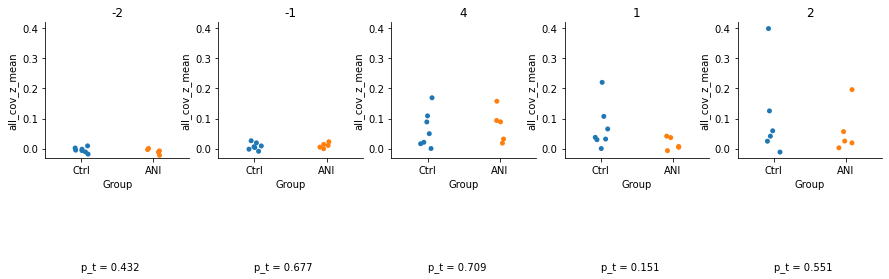

In [31]:
pairs_plot = ['-2_-1', '-1_4', '4_1', '1_2', '2_7']
fig, ax = plt.subplots(1, len(pairs_plot), figsize=(3*len(pairs_plot), 2.5))
for a, d1_d2 in zip(ax, pairs_plot):
    sns.stripplot(x='Group', y='all_cov_z_mean', data=sigz_all_df[sigz_all_df['d1_d2'] == d1_d2], ax=a)
    sns.despine(ax=a)
    a.set_title(d1_d2.split('_')[0])
    df_use = sigz_all_df[sigz_all_df['d1_d2'] == d1_d2]
    stat, pval = stats.ttest_ind(df_use[df_use['Group'] == 'Ctrl']['all_cov_z_mean'], 
                                 df_use[df_use['Group'] == 'ANI']['all_cov_z_mean'])
    
    a.text(0, -0.4, f'p_t = {pval:.3g}')
    
match_max_lims(ax, axis='y')
stats_before_after(sigz_all_df, 'all_cov_z_mean')

### Next step: What does this look like for neutral arena? Would expect less increases/changes there for all groups, except maybe non-learners since they generalize to both arenas.

### Step after: plot changes in tightly coupled cells from day 4 to day 1, 2, 7 - grab cells with covariance > 2 std above the mean.  Then calculate mean absolute CHANGE in covariance from day 4 to following days. Hypothesis is that Ctrl change is less than ANI change since ANI will prevent consolidation of any short-term plasticity that occurs during 4 hour session.

## Add in Marble06 and do outlier sensitivity analysis - is it the same outlier for Ctrl on day 1 and 2? What if I remove it on both days and the ANI outlier too?

# NRK, compare in supplemental to data from 2-env task across 1st four days - what covariance levels do we see across days for them? Does the shock increase covariance? Why do we see increases in ANI group too?

## Plot pairwise changes in covariance across sessions

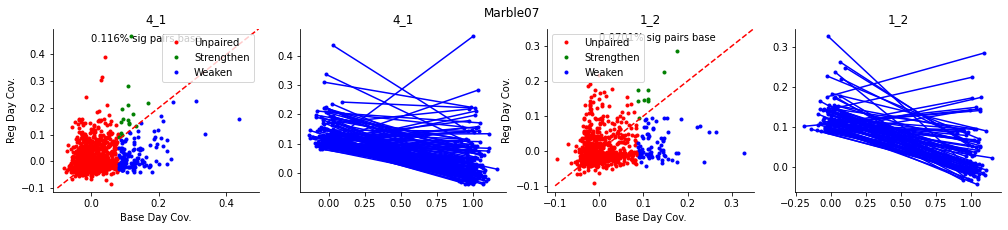

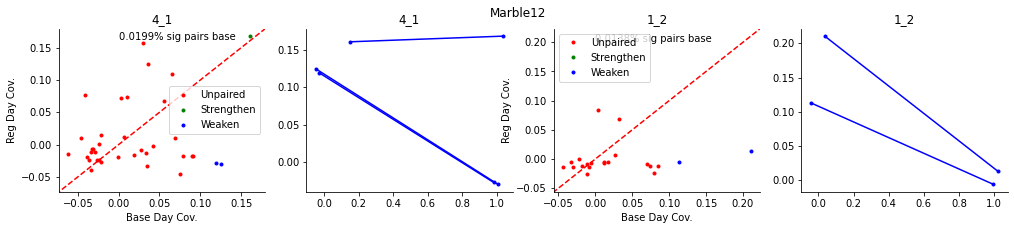

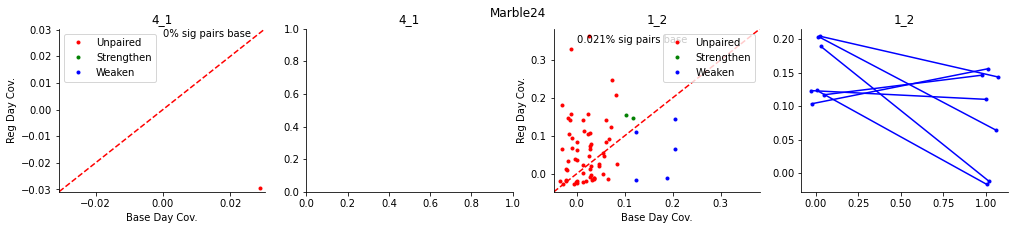

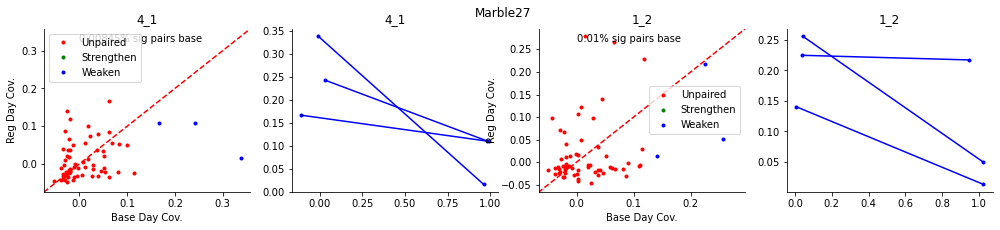

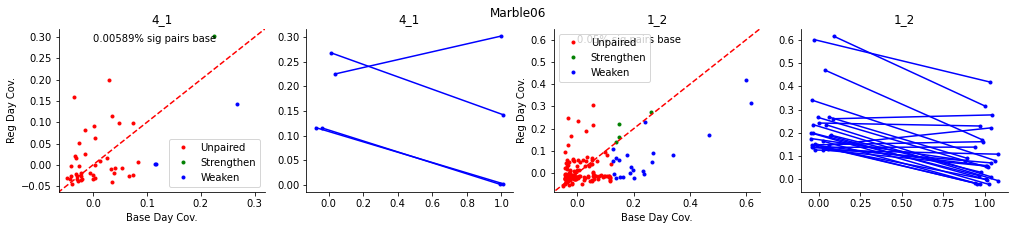

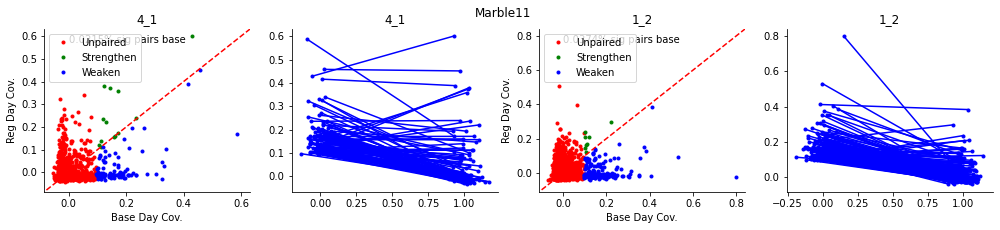

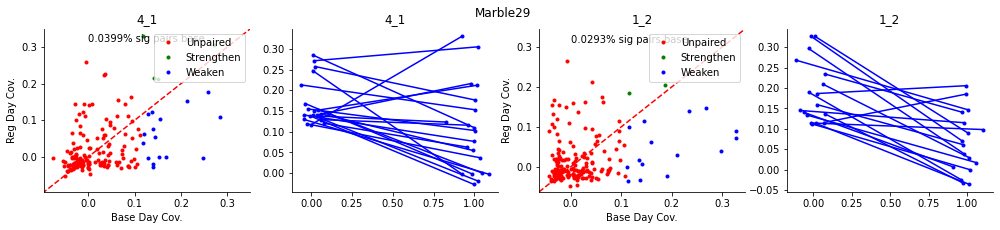

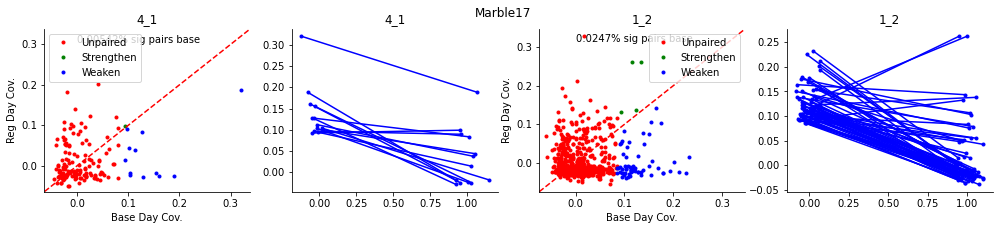

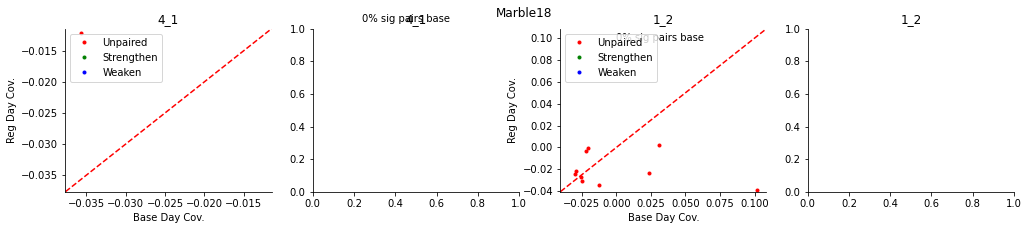

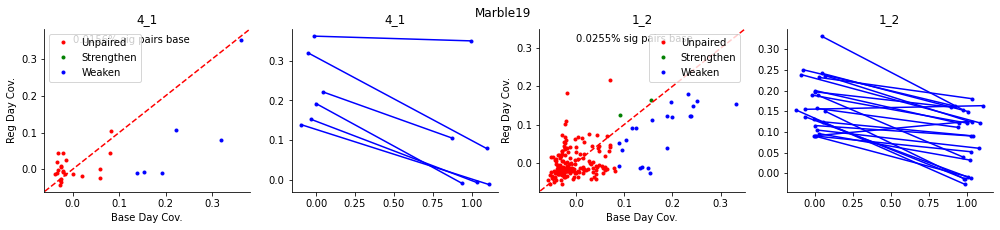

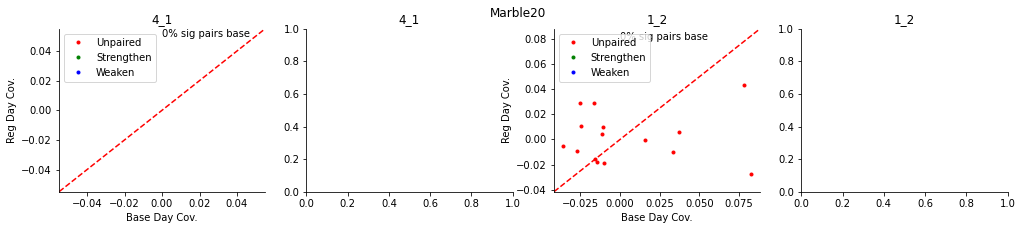

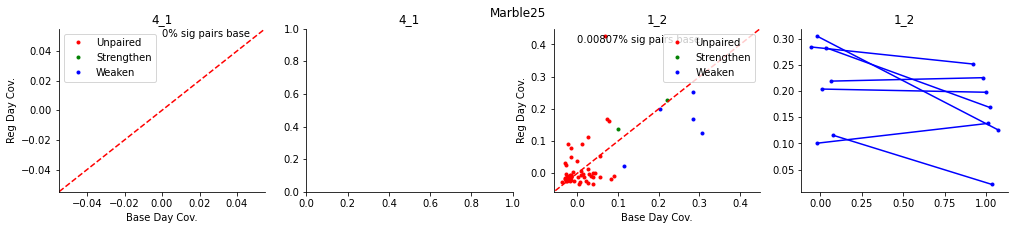

In [19]:
dict_use = freeze_silent_cov
pairs_plot = ['4_1', '1_2']
include_silent = False
sig_pairs_plot = 'base'  # 'base' or 'reg' or 'either'
thresh = 2 # std above the mean to be considered significantly co-tuned
for group_name in dict_use.keys():
    group_dict = dict_use[group_name]
    for mouse_name in group_dict.keys():
        mouse_dict = group_dict[mouse_name]
        fig, axp = plt.subplots(1, 4, figsize=(17, 3))
        fig.suptitle(mouse_name)
        for idd, d1_d2 in enumerate(pairs_plot):
            try:
                full_mat_use = cov_dict_full[group_name][mouse_name][d1_d2]
                mat_use = dict_use[group_name][mouse_name][d1_d2]

                tril_indices = np.tril_indices_from(full_mat_use, -1)
                npairs_full = len(tril_indices[0])
                sig_thresh = thresh * np.std(full_mat_use[tril_indices[0], tril_indices[1]])
                _ = fa.scatter_cov_across_days(mat_use, label_by_state=True, sig_thresh=sig_thresh, 
                                               ax=axp[0 + 2 * idd], include_silent=include_silent)
                axp[0 + 2 * idd].set_title(d1_d2)

                base_cov, reg_cov = fa.get_cov_pairs_from_mat(mat_use, None, include_silent=include_silent)
                jitter = 0.05
                if sig_pairs_plot == 'either':
                    thresh_bool = np.bitwise_or(base_cov > sig_thresh, reg_cov > sig_thresh)
                elif sig_pairs_plot == 'base':
                    thresh_bool = base_cov > sig_thresh
                elif sig_pairs_plot == 'reg':
                    thresh_bool = reg_cov > sig_thresh
                nsigpairs = np.sum(thresh_bool)
                axp[0 + 2 * idd].text(0, axp[0 + 2 * idd].get_ylim()[1]*0.9, 
                                      f'{nsigpairs/npairs_full*100:0.3g}% sig pairs {sig_pairs_plot}')

                for base, reg in zip(base_cov[thresh_bool], reg_cov[thresh_bool]):
                    axp[1 + 2 * idd].plot([np.random.randn(1)*jitter, np.random.randn(1)*jitter + 1], 
                               [base, reg], 'b.-')
                axp[1 + 2 * idd].set_title(d1_d2)

                sns.despine(ax=axp[1 + 2* idd])
            except KeyError:
                pass
            

In [20]:
dict_use = freeze_silent_cov
pairs_plot = ['-2_-1', '-1_4', '4_1', '1_2', '2_7']
sig_pairs_plot = 'base'  # 'base' or 'reg' or 'either'

day_code, group_code, sigpctfull, sigpctfreeze = [], [], [], [] # pre-allocate for plotting!
for group_name in dict_use.keys():
    group_dict = dict_use[group_name]
    for mouse_name in group_dict.keys():
        mouse_dict = group_dict[mouse_name]
        for idd, d1_d2 in enumerate(pairs_plot):
            try:
                full_mat_use = cov_dict_full[group_name][mouse_name][d1_d2]
                mat_use = dict_use[group_name][mouse_name][d1_d2]

                tril_indices = np.tril_indices_from(full_mat_use, -1)
                tril_indices_freeze = np.tril_indices_from(mat_use, -1)
                npairs_full = len(tril_indices[0])
                npairs_freeze = len(tril_indices_freeze[0])
                sig_thresh = 2 * np.std(full_mat_use[tril_indices[0], tril_indices[1]])
                base_cov, reg_cov = fa.get_cov_pairs_from_mat(mat_use, None, include_silent=True)
                if sig_pairs_plot == 'either':
                    thresh_bool = np.bitwise_or(base_cov > sig_thresh, reg_cov > sig_thresh)
                elif sig_pairs_plot == 'base':
                    thresh_bool = base_cov > sig_thresh
                elif sig_pairs_plot == 'reg':
                    thresh_bool = reg_cov > sig_thresh
                nsigpairs = np.sum(thresh_bool)

                # Build up lists for dumping into dataframe
                group_code.append('ANI') if group_name == 'ANI' else group_code.append('Ctrl')
                day_code.append(d1_d2)
                sigpctfull.append(nsigpairs/npairs_full*100)
                sigpctfreeze.append(nsigpairs/npairs_freeze*100)
            except KeyError:
                pass

sigpairs_df = pd.DataFrame(data={'d1_d2' : day_code, 'Group': group_code, 'SigPctFull': sigpctfull, 
                                'SigPctFreeze': sigpctfreeze})                       

# Plot % of freeze-tuned cells with significant co-activation on each day

### NRK - missing Marble06 from day 2 plots since he does not have a day 7 plot and I'm using across day cov. mats to get the data - fix for below somehow!

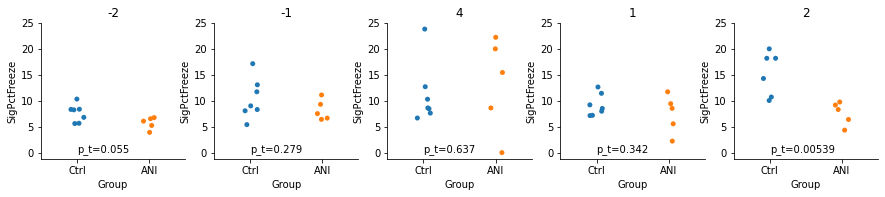

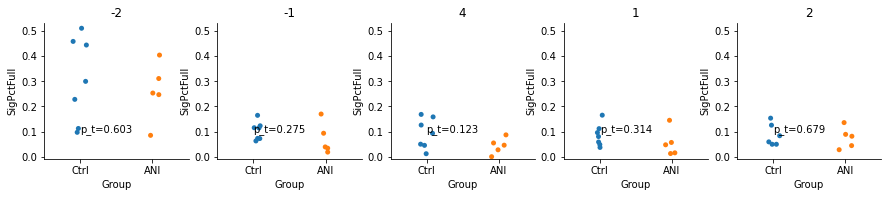

In [21]:
fig, ax = plt.subplots(1, len(pairs_plot), figsize=(3*len(pairs_plot), 2.5))
pairs_plot = ['-2_-1', '-1_4', '4_1', '1_2', '2_7']
for a, d1_d2 in zip(ax, pairs_plot):
    sns.stripplot(x='Group', y='SigPctFreeze', data=sigpairs_df[sigpairs_df['d1_d2'] == d1_d2], ax=a)
    sns.despine(ax=a)
    a.set_title(d1_d2.split('_')[0])
    grp1 = sigpairs_df.loc[(sigpairs_df['Group'] == 'Ctrl') & (sigpairs_df['d1_d2'] == d1_d2)]['SigPctFreeze']
    grp2 = sigpairs_df.loc[(sigpairs_df['Group'] == 'ANI') & (sigpairs_df['d1_d2'] == d1_d2)]['SigPctFreeze']
    stat, pval = stats.ttest_ind(grp1, grp2)
    a.text(0, 0.1, f'p_t={pval:0.3g}')
    
match_max_lims(ax, axis='y')
    
fig, ax = plt.subplots(1, len(pairs_plot), figsize=(3*len(pairs_plot), 2.5))
for a, d1_d2 in zip(ax, pairs_plot):
    sns.stripplot(x='Group', y='SigPctFull', data=sigpairs_df[sigpairs_df['d1_d2'] == d1_d2], ax=a)
    sns.despine(ax=a)
    a.set_title(d1_d2.split('_')[0])
    grp1 = sigpairs_df.loc[(sigpairs_df['Group'] == 'Ctrl') & (sigpairs_df['d1_d2'] == d1_d2)]['SigPctFull']
    grp2 = sigpairs_df.loc[(sigpairs_df['Group'] == 'ANI') & (sigpairs_df['d1_d2'] == d1_d2)]['SigPctFull']
    stat, pval = stats.ttest_ind(grp1, grp2)
    a.text(0, 0.1, f'p_t={pval:0.3g}')

match_max_lims(ax, axis='y')

Now combine days before and after and run test across AND within groups.

In [31]:
from scipy.stats import ttest_ind
daypair = '2_7'
sigpairs_bef = sigpairs_df[np.bitwise_or(sigpairs_df['d1_d2'] == '-2_-1', sigpairs_df['d1_d2'] == '-1_4')]
sigpairs_aft = sigpairs_df[np.bitwise_or(sigpairs_df['d1_d2'] == '1_2', sigpairs_df['d1_d2'] == '2_7')]

ctrl_bef = sigpairs_bef[sigpairs_bef['Group'] == 'Ctrl']['SigPctFreeze']
ani_bef = sigpairs_bef[sigpairs_bef['Group'] == 'ANI']['SigPctFreeze']
ctrl_aft = sigpairs_aft[sigpairs_aft['Group'] == 'Ctrl']['SigPctFreeze']
ani_aft = sigpairs_aft[sigpairs_aft['Group'] == 'ANI']['SigPctFreeze']

stat_bef, pval_bef = ttest_ind(ctrl_bef, ani_bef)
print(f'p={pval_bef:0.3g} Ctrl v ANI before shock')

stat_aft, pval_aft = ttest_ind(ctrl_aft, ani_aft)
print(f'p={pval_aft:0.3g} Ctrl v ANI after shock')

stat_ctrl, p_ctrl = ttest_ind(ctrl_aft, ctrl_bef)
print(f'p={p_ctrl:0.3g} Ctrl before v after')

stat_ani, p_ani = ttest_ind(ani_aft, ani_bef)
print(f'p={p_ani:0.3g} Ani before v after')

p=0.0901 Ctrl v ANI before shock
p=0.0123 Ctrl v ANI after shock
p=0.0569 Ctrl before v after
p=0.6 Ani before v after


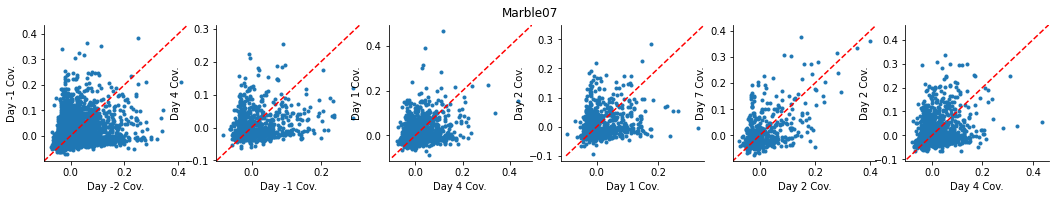

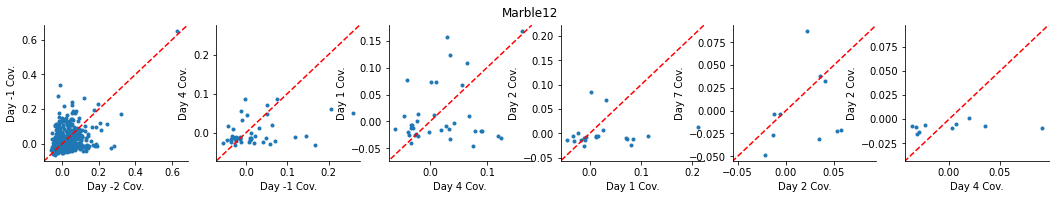

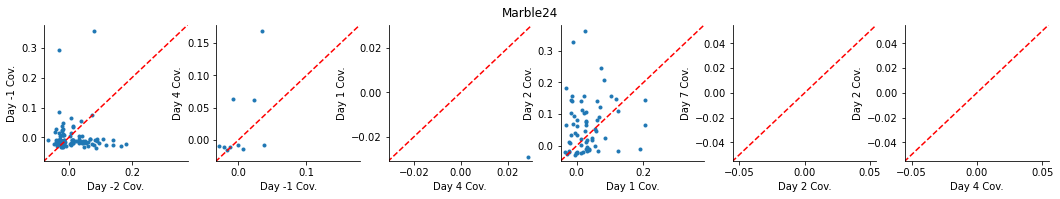

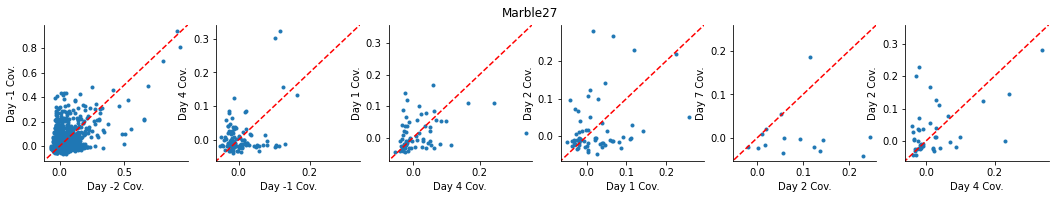

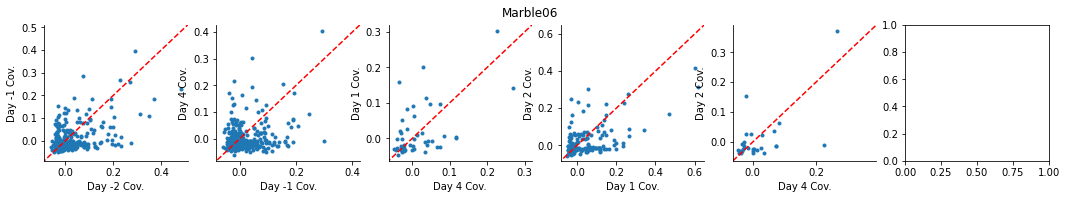

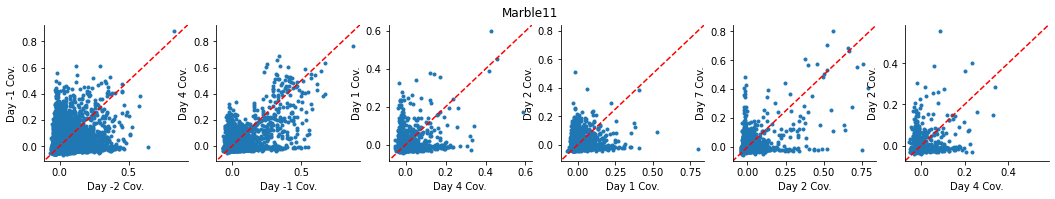

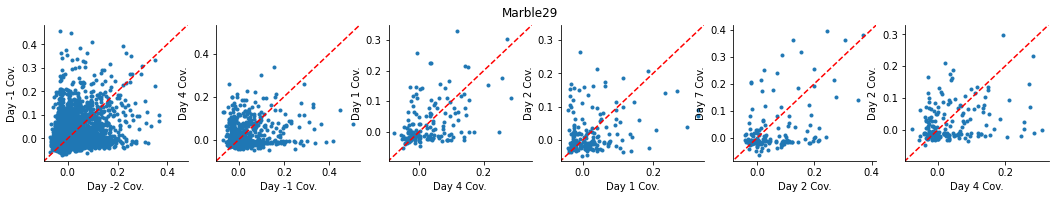

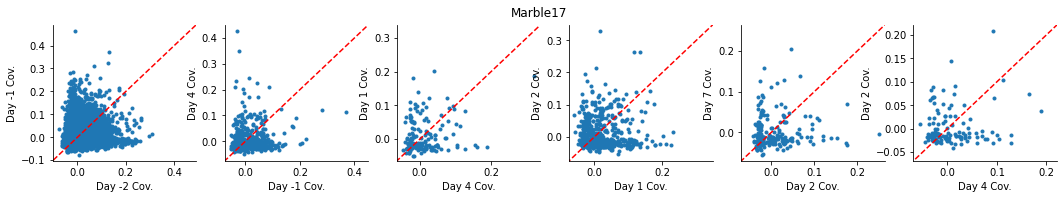

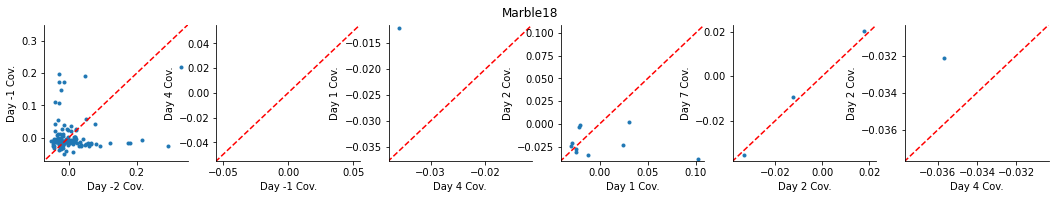

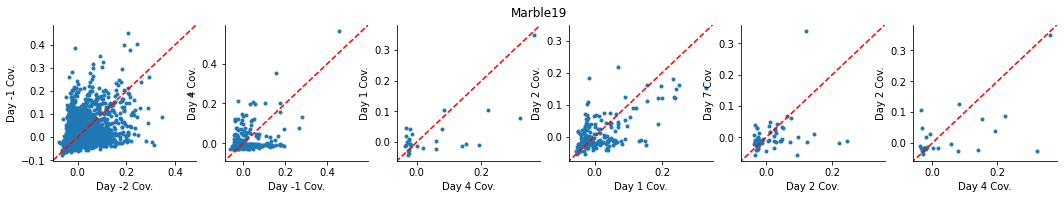

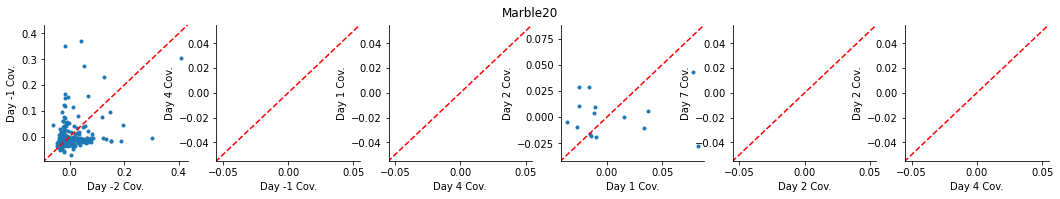

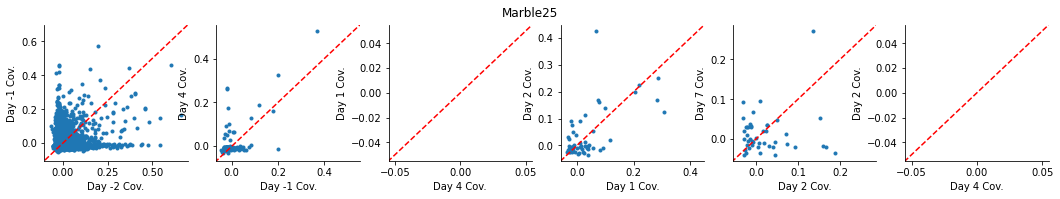

In [23]:
freeze_silent_cov = np.load(os.path.join(save_dir, 'freeze_cells_cov_across_days_w_silent.npy'),
                           allow_pickle=True).item()
ndays = 6

plot_pw_cov_across_days(freeze_silent_cov, 6, False)

ANI mice appear to have almost no cells strengthening their freeze related tuning from hr 4 to day 1, despite having a lot of cells that do continue to fire together from day -1 to hr 4. Quantify by counting up # of strengthened (above diagonal) vs # weakened (below diagonal) cells.  Must have cov > 2sd of mean of whole matrix to be considered a candidate pair....  Work with percentages.  Can also plot # of cells across days and show paired with lines connecting (would have to compare to day -2/-1 baseline...)

Do for other days too to show that things don't change as much.

## Other random plots below here

Calculating Dupret activations from raw calcium activity
Calculating Dupret activations from raw calcium activity


array([[<AxesSubplot:title={'center':'PCA 0'}, ylabel='freeze starts #'>,
        <AxesSubplot:title={'center':'PCA 1'}>,
        <AxesSubplot:title={'center':'PCA 2'}>,
        <AxesSubplot:title={'center':'PCA 3'}>,
        <AxesSubplot:title={'center':'PCA 4'}>],
       [<AxesSubplot:title={'center':'PCA 5'}, ylabel='freeze starts #'>,
        <AxesSubplot:title={'center':'PCA 6'}>,
        <AxesSubplot:title={'center':'PCA 7'}>,
        <AxesSubplot:title={'center':'PCA 8'}>,
        <AxesSubplot:title={'center':'PCA 9'}>],
       [<AxesSubplot:title={'center':'PCA 10'}, ylabel='freeze starts #'>,
        <AxesSubplot:title={'center':'PCA 11'}>,
        <AxesSubplot:title={'center':'PCA 12'}>,
        <AxesSubplot:title={'center':'PCA 13'}>,
        <AxesSubplot:title={'center':'PCA 14'}>],
       [<AxesSubplot:title={'center':'PCA 15'}, ylabel='freeze starts #'>,
        <AxesSubplot:title={'center':'PCA 16'}>,
        <AxesSubplot:title={'center':'PCA 17'}>,
        <AxesSubplot:

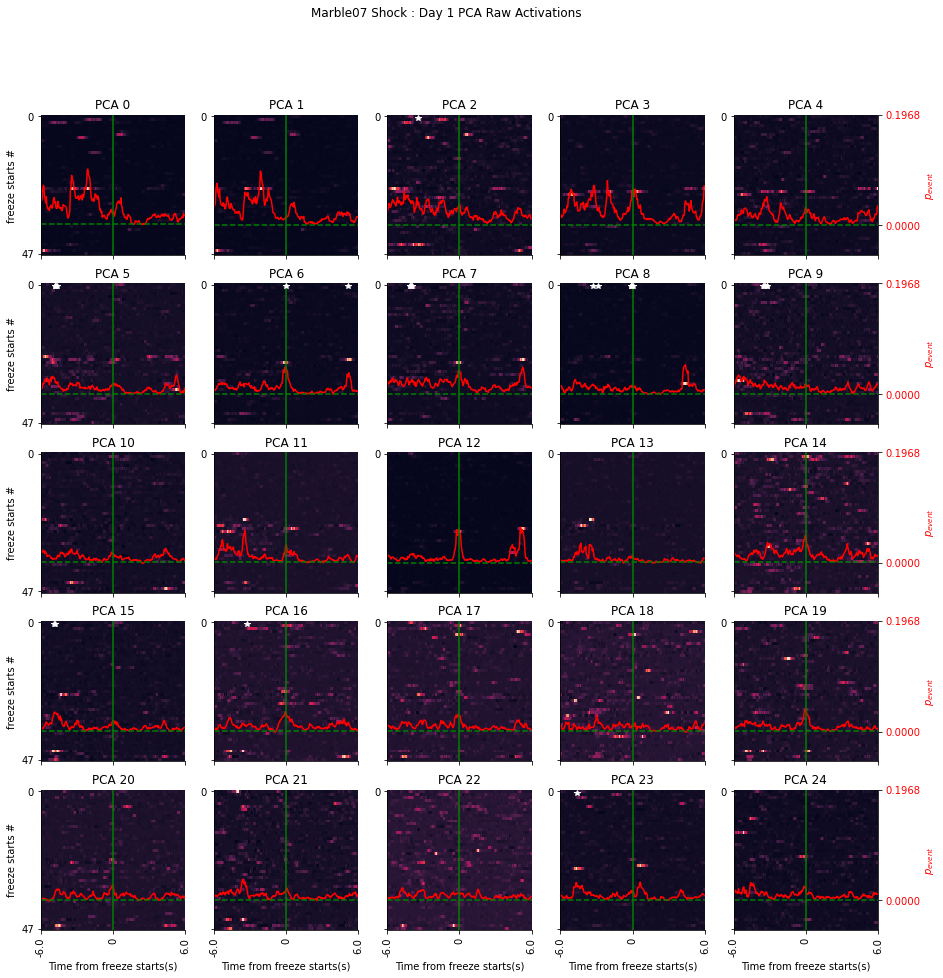

In [24]:
DR = fa.DimReduction('Marble07', 'Shock', 1)
DR.get_tuning_sig('freeze_onset', 6, nperm=1000, dr_type='pca')
DR.plot_rasters(dr_type='pca')

Calculating Dupret activations from raw calcium activity
Calculating Dupret activations from raw calcium activity


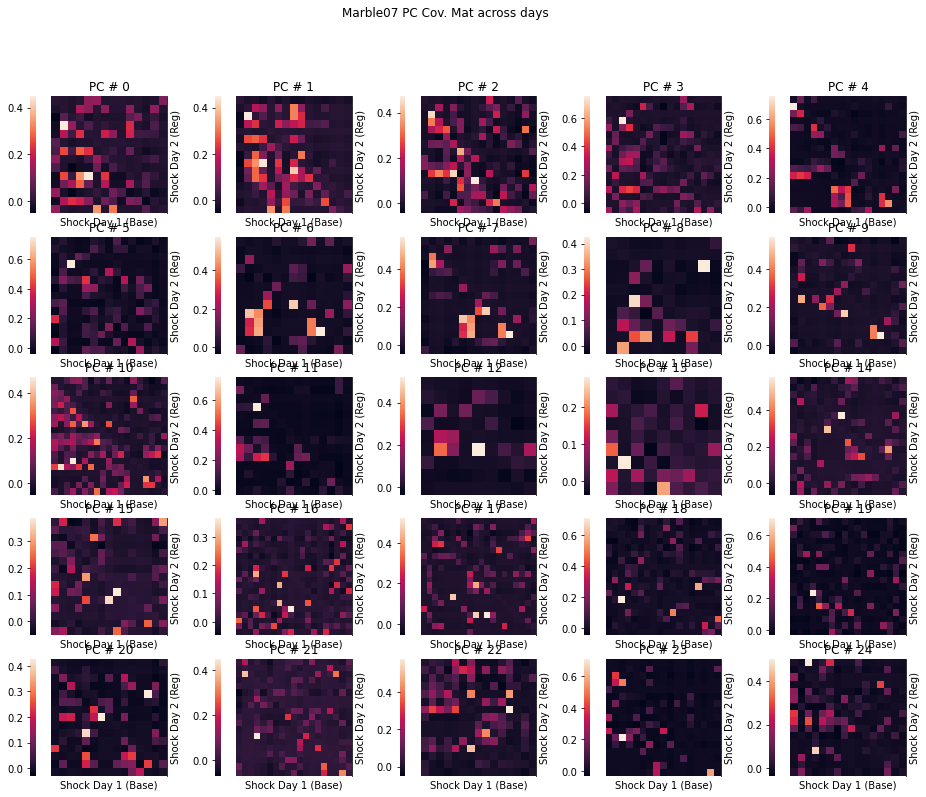

In [25]:
# Plot All PCs across days for one mouse
plot_dir = '/Users/nkinsky/Documents/BU/Working/Eraser/plots'
group_plot = [err.learners, err.nonlearners, err.ani_mice_good]
group_names = ['Learners', 'Non-learners', 'ANI']
mouse = 'Marble07'
d1 = 1
d2 = 2
DRreg = fa.DimReductionReg(mouse, 'Shock', d1, 'Shock', d2, random_state=1)
ncols = 5
nrows = np.ceil(DRreg.DRbase.nA/ncols).astype(int)
fig, ax = plt.subplots(nrows , ncols, figsize=(3.2*ncols, 2.5*nrows))
fig.suptitle(mouse + " PC Cov. Mat across days")
for ida, a in enumerate(ax.reshape(-1)):
    sig_wts = np.where(DRreg.DRbase.pca.df[ida].abs() > DRreg.DRbase.pca.df[ida].std()*2)[0]
    DRreg.plot_cov_across_days(neurons=sig_wts, label='PC #' + str(ida), ax=a)
    a.set_title('PC # ' + str(ida))
